# Test Various CNN architectures on the layer identification task


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from Classifier_models import CNN1D_Small, CNN1D_Large, train_model, identify_device

## Import Data 

In [16]:
device = identify_device()

Using device: cuda


In [17]:
# Load the dataset with weights_only=False
data = torch.load("Synthetic_data_60k.pt", weights_only=False)

# Extract components
synthetic_data = data["synthetic_data"]
material_params = data["material_params"]
num_layers = data["num_layers"]

print("Dataset loaded successfully!")
print(f"Number of samples: {len(synthetic_data)}")
print(f"Shape of synthetic_data: {synthetic_data.shape}")
print(f"Shape of num_layers: {num_layers.shape}")
print(f"Example number of layers: {num_layers[:10]}")

num_classes = int(max(num_layers)) # class labels start at 1 not 0.

Dataset loaded successfully!
Number of samples: 60000
Shape of synthetic_data: torch.Size([60000, 1024])
Shape of num_layers: torch.Size([60000])
Example number of layers: tensor([3, 3, 2, 1, 3, 2, 3, 1, 1, 3])


In [18]:
# Adjust labels for training (CrossEntropyLoss expects 0-based class labels)
num_layers_adjusted = num_layers - 1  # Convert labels from 1–5 → 0–4

# Ensure shapes are as expected
print("synthetic_data shape (after unsqueeze):", synthetic_data.unsqueeze(1).shape)
print("num_layers (original):", num_layers[:10])
print("num_layers_adjusted (for training):", num_layers_adjusted[:10])


synthetic_data shape (after unsqueeze): torch.Size([60000, 1, 1024])
num_layers (original): tensor([3, 3, 2, 1, 3, 2, 3, 1, 1, 3])
num_layers_adjusted (for training): tensor([2, 2, 1, 0, 2, 1, 2, 0, 0, 2])


In [19]:
num_classes = int(num_layers_adjusted.max().item()) + 1  # e.g., 5 if max label is 4
batch_size = 1024

# Unsqueeze to add channel dimension for Conv1D input: [B, 1, 1024]
synthetic_data = synthetic_data.unsqueeze(1)  # [100, 1, 1024]

# Create TensorDataset with adjusted labels
train_dataset = TensorDataset(synthetic_data, num_layers_adjusted)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Train and Test Small CNN

In [20]:
# Initialize the model, criterion, and optimizer
model = CNN1D_Small(input_channels=1, num_classes=num_classes).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optional: Print shapes and label stats for sanity check
print("Data shape:", synthetic_data.shape)
print("Label range:", num_layers_adjusted.min().item(), "to", num_layers_adjusted.max().item())
print("Number of classes:", num_classes)

Data shape: torch.Size([60000, 1, 1024])
Label range: 0 to 2
Number of classes: 3


Epoch 1/30: 100%|██████████| 59/59 [00:01<00:00, 38.73batch/s, loss=1.1]


Epoch [1/30], Loss: 1.0973


Epoch 2/30: 100%|██████████| 59/59 [00:01<00:00, 51.61batch/s, loss=0.995]


Epoch [2/30], Loss: 0.9949


Epoch 3/30: 100%|██████████| 59/59 [00:01<00:00, 45.18batch/s, loss=0.923]


Epoch [3/30], Loss: 0.9235


Epoch 4/30: 100%|██████████| 59/59 [00:01<00:00, 50.42batch/s, loss=0.897]


Epoch [4/30], Loss: 0.8967


Epoch 5/30: 100%|██████████| 59/59 [00:01<00:00, 45.02batch/s, loss=0.872]


Epoch [5/30], Loss: 0.8717


Epoch 6/30: 100%|██████████| 59/59 [00:01<00:00, 50.92batch/s, loss=0.845]


Epoch [6/30], Loss: 0.8449


Epoch 7/30: 100%|██████████| 59/59 [00:01<00:00, 44.46batch/s, loss=0.824]


Epoch [7/30], Loss: 0.8241


Epoch 8/30: 100%|██████████| 59/59 [00:01<00:00, 49.77batch/s, loss=0.788]


Epoch [8/30], Loss: 0.7880


Epoch 9/30: 100%|██████████| 59/59 [00:01<00:00, 45.34batch/s, loss=0.752]


Epoch [9/30], Loss: 0.7516


Epoch 10/30: 100%|██████████| 59/59 [00:01<00:00, 50.53batch/s, loss=0.709]


Epoch [10/30], Loss: 0.7093


Epoch 11/30: 100%|██████████| 59/59 [00:01<00:00, 44.78batch/s, loss=0.67] 


Epoch [11/30], Loss: 0.6701


Epoch 12/30: 100%|██████████| 59/59 [00:01<00:00, 50.53batch/s, loss=0.645]


Epoch [12/30], Loss: 0.6446


Epoch 13/30: 100%|██████████| 59/59 [00:01<00:00, 44.88batch/s, loss=0.62] 


Epoch [13/30], Loss: 0.6199


Epoch 14/30: 100%|██████████| 59/59 [00:01<00:00, 51.26batch/s, loss=0.601]


Epoch [14/30], Loss: 0.6013


Epoch 15/30: 100%|██████████| 59/59 [00:01<00:00, 45.34batch/s, loss=0.581]


Epoch [15/30], Loss: 0.5812


Epoch 16/30: 100%|██████████| 59/59 [00:01<00:00, 51.01batch/s, loss=0.578]


Epoch [16/30], Loss: 0.5778


Epoch 17/30: 100%|██████████| 59/59 [00:01<00:00, 44.79batch/s, loss=0.571]


Epoch [17/30], Loss: 0.5708


Epoch 18/30: 100%|██████████| 59/59 [00:01<00:00, 50.53batch/s, loss=0.563]


Epoch [18/30], Loss: 0.5628


Epoch 19/30: 100%|██████████| 59/59 [00:01<00:00, 44.78batch/s, loss=0.56] 


Epoch [19/30], Loss: 0.5601


Epoch 20/30: 100%|██████████| 59/59 [00:01<00:00, 49.78batch/s, loss=0.55] 


Epoch [20/30], Loss: 0.5495


Epoch 21/30: 100%|██████████| 59/59 [00:01<00:00, 43.05batch/s, loss=0.545]


Epoch [21/30], Loss: 0.5449


Epoch 22/30: 100%|██████████| 59/59 [00:01<00:00, 49.52batch/s, loss=0.538]


Epoch [22/30], Loss: 0.5382


Epoch 23/30: 100%|██████████| 59/59 [00:01<00:00, 44.25batch/s, loss=0.524]


Epoch [23/30], Loss: 0.5236


Epoch 24/30: 100%|██████████| 59/59 [00:01<00:00, 49.05batch/s, loss=0.539]


Epoch [24/30], Loss: 0.5386


Epoch 25/30: 100%|██████████| 59/59 [00:01<00:00, 44.16batch/s, loss=0.515]


Epoch [25/30], Loss: 0.5149


Epoch 26/30: 100%|██████████| 59/59 [00:01<00:00, 49.34batch/s, loss=0.55] 


Epoch [26/30], Loss: 0.5495


Epoch 27/30: 100%|██████████| 59/59 [00:01<00:00, 49.06batch/s, loss=0.577]


Epoch [27/30], Loss: 0.5765


Epoch 28/30: 100%|██████████| 59/59 [00:01<00:00, 44.17batch/s, loss=0.527]


Epoch [28/30], Loss: 0.5273


Epoch 29/30: 100%|██████████| 59/59 [00:01<00:00, 49.52batch/s, loss=0.526]


Epoch [29/30], Loss: 0.5264


Epoch 30/30: 100%|██████████| 59/59 [00:01<00:00, 43.96batch/s, loss=0.509]


Epoch [30/30], Loss: 0.5094


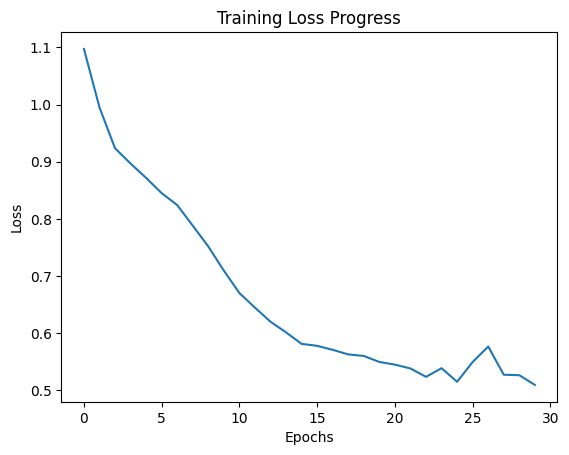

In [21]:
# Train the model
loss_values = train_model(model, train_loader, criterion, optimizer, device=device, num_epochs=30)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.show()


 Unseen dataset Accuracy: 0.7750


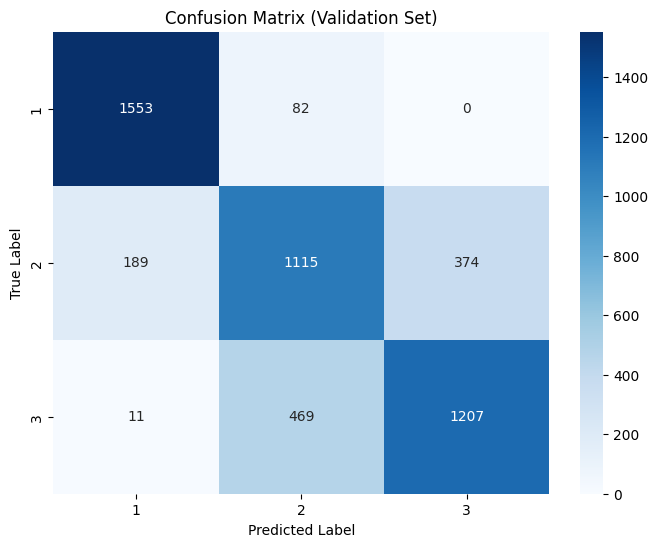

In [22]:
# Load the validation dataset
val_data = torch.load("Validation.pt", weights_only=False)

val_synthetic_data = val_data["synthetic_data"]         # shape: [N, 1024]
val_num_layers = val_data["num_layers"]                 # shape: [N]
val_num_layers_adjusted = val_num_layers - 1            # match training label indexing

# Unsqueeze to match model input shape
val_synthetic_data = val_synthetic_data.unsqueeze(1)    # shape: [N, 1, 1024]

# Create DataLoader for validation
val_dataset = TensorDataset(val_synthetic_data, val_num_layers_adjusted)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())   # move back to CPU before numpy
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix and accuracy
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

print(f"\n Unseen dataset Accuracy: {acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i+1}" for i in range(cm.shape[0])],
            yticklabels=[f"{i+1}" for i in range(cm.shape[0])])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

## Train and test Larger CNN

In [12]:
# Initialize the model, criterion, and optimizer
model = CNN1D_Large(input_channels=1, num_classes=num_classes).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optional: Print shapes and label stats for sanity check
print("Data shape:", synthetic_data.shape)
print("Label range:", num_layers_adjusted.min().item(), "to", num_layers_adjusted.max().item())
print("Number of classes:", num_classes)

Data shape: torch.Size([60000, 1, 1024])
Label range: 0 to 2
Number of classes: 3


Epoch 1/10: 100%|██████████| 59/59 [00:03<00:00, 15.35batch/s, loss=0.574]


Epoch [1/10], Loss: 0.5740


Epoch 2/10: 100%|██████████| 59/59 [00:03<00:00, 17.23batch/s, loss=0.353]


Epoch [2/10], Loss: 0.3525


Epoch 3/10: 100%|██████████| 59/59 [00:03<00:00, 16.44batch/s, loss=0.295]


Epoch [3/10], Loss: 0.2952


Epoch 4/10: 100%|██████████| 59/59 [00:03<00:00, 17.21batch/s, loss=0.259]


Epoch [4/10], Loss: 0.2586


Epoch 5/10: 100%|██████████| 59/59 [00:03<00:00, 16.55batch/s, loss=0.238]


Epoch [5/10], Loss: 0.2381


Epoch 6/10: 100%|██████████| 59/59 [00:03<00:00, 17.15batch/s, loss=0.253]


Epoch [6/10], Loss: 0.2533


Epoch 7/10: 100%|██████████| 59/59 [00:03<00:00, 16.40batch/s, loss=0.228]


Epoch [7/10], Loss: 0.2280


Epoch 8/10: 100%|██████████| 59/59 [00:03<00:00, 17.18batch/s, loss=0.223]


Epoch [8/10], Loss: 0.2231


Epoch 9/10: 100%|██████████| 59/59 [00:03<00:00, 16.44batch/s, loss=0.199]


Epoch [9/10], Loss: 0.1992


Epoch 10/10: 100%|██████████| 59/59 [00:03<00:00, 17.34batch/s, loss=0.211]


Epoch [10/10], Loss: 0.2105


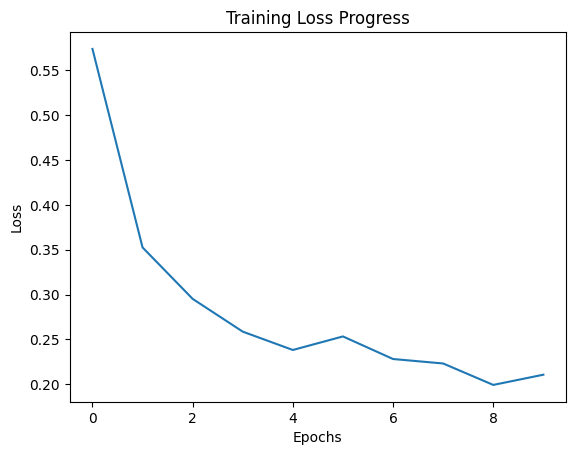

In [13]:
# Train the model
loss_values = train_model(model, train_loader, criterion, optimizer, device=device, num_epochs=10)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.show()


Validation Accuracy: 0.3292


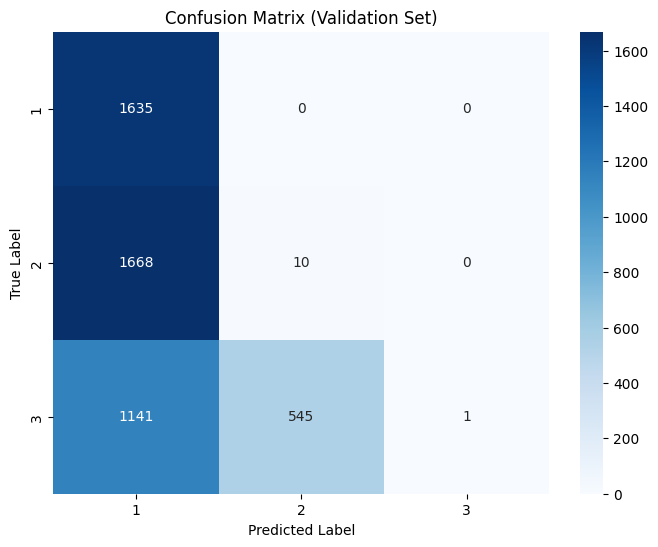

In [ ]:
# Load the validation dataset
val_data = torch.load("Validation.pt", weights_only=False)

val_synthetic_data = val_data["synthetic_data"]         # shape: [N, 1024]
val_num_layers = val_data["num_layers"]                 # shape: [N]
val_num_layers_adjusted = val_num_layers - 1            # match training label indexing

# Unsqueeze to match model input shape
val_synthetic_data = val_synthetic_data.unsqueeze(1)    # shape: [N, 1, 1024]

# Create DataLoader for validation
val_dataset = TensorDataset(val_synthetic_data, val_num_layers_adjusted)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())   # move back to CPU before numpy
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix and accuracy
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

print(f"\nUnseen Accuracy: {acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i+1}" for i in range(cm.shape[0])],
            yticklabels=[f"{i+1}" for i in range(cm.shape[0])])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()